# Ejercicio 2¶

In [91]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats

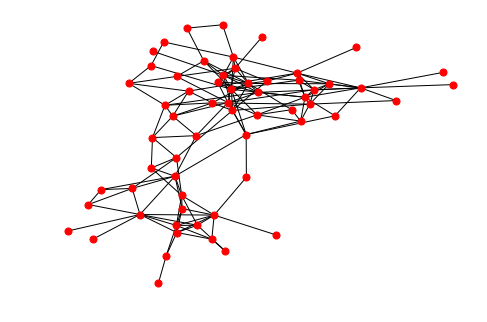

In [92]:
G=nx.read_gml('dolphins.gml')
nx.draw(G, with_labels=False, font_weight='bold',node_size=50)
plt.show()
#list(G)

In [93]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

data_gender=ldata('dolphinsGender.txt')

data_gender
colores=[]

#le agregamos el atributo "genero" al grafo G
for elemento in data_gender:
    G.node[elemento[0]]['genero']=elemento[1]
    
#creamos un vector de colores que vincula los generos (mismo orden)     
for gen in nx.get_node_attributes(G, "genero").values():
    if gen=='f':
        colores.append('red')
    elif gen=='m':
        colores.append('blue')
    else:
        colores.append('grey')
        


In [94]:
#verificamos el vector colores
#nx.get_node_attributes(G, "genero").values()

### Asi se accede a las propiedades de un nodo:
#G.node['Ripplefluke']

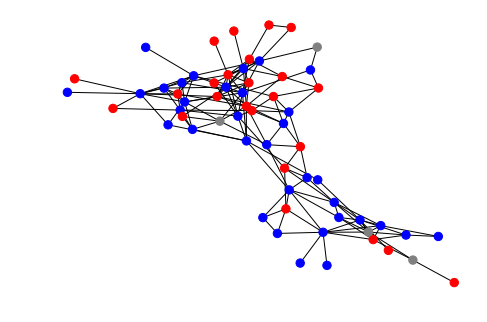

In [95]:
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_size=70,node_grouping='genero')
plt.show()

In [117]:
def delta_kronecker(x,y):
    resultado=0
    if x=='NA' or y== 'NA':
        resultado=1
    elif x==y:
        resultado=1
    return resultado
## TAREA: imprimir el grado de los NA

In [118]:
'''
def modularity(G):
    A = nx.adjacency_matrix(G)  # Matriz de adycencia
    m = G.number_of_edges()
    v=0
    sumando = 0.0
    for node_v in G:      # Loop de nodo v
        genero_v = nx.get_node_attributes(G, "genero").values()[v]
        kv= list(G.degree)[v][1]
        w=0
        for node_w in G:  # Loop de nodo w
            genero_w = nx.get_node_attributes(G, "genero").values()[w]
            if( delta_kronecker(genero_v,genero_w)):
                kw= list(G.degree)[w][1]
                A_vw = A[v,w]
                sumando += A_vw-(kv*kw)/(2.0*m)
            w+=1
        v+=1
    Q = sumando/(2.0*m)
    return round(Q,3)
modularity(G)
'''

'\ndef modularity(G):\n    A = nx.adjacency_matrix(G)  # Matriz de adycencia\n    m = G.number_of_edges()\n    v=0\n    sumando = 0.0\n    for node_v in G:      # Loop de nodo v\n        genero_v = nx.get_node_attributes(G, "genero").values()[v]\n        kv= list(G.degree)[v][1]\n        w=0\n        for node_w in G:  # Loop de nodo w\n            genero_w = nx.get_node_attributes(G, "genero").values()[w]\n            if( delta_kronecker(genero_v,genero_w)):\n                kw= list(G.degree)[w][1]\n                A_vw = A[v,w]\n                sumando += A_vw-(kv*kw)/(2.0*m)\n            w+=1\n        v+=1\n    Q = sumando/(2.0*m)\n    return round(Q,3)\nmodularity(G)\n'

In [157]:
def enlaces_na(G):
    i=0
    enlaces_NA=0
    for nodo in G:
        if nx.get_node_attributes(G, "genero").values()[i]=='NA':
            enlaces_NA+=list(G.degree)[i][1]
        i+=1
        
    return enlaces_NA        
enlaces_na(G)

19

In [162]:
def modularity2(G): ## calcula la fraccion de enlaces entre nodos de distinto genero
    A = nx.adjacency_matrix(G)  # Matriz de adycencia
    m = G.number_of_edges()
    m = m - enlaces_na(G)
    v=0
    sumando = 0.0
    for node_v in G:      # Loop de nodo v
        genero_v = nx.get_node_attributes(G, "genero").values()[v]
        w=0
        for node_w in G:  # Loop de nodo w
            genero_w = nx.get_node_attributes(G, "genero").values()[w]
            if( not delta_kronecker(genero_v,genero_w)):
                A_vw = A[v,w]
                sumando += A_vw
            w+=1
        v+=1
    Q = sumando/(2.0*m)
    return round(Q,3)
modularity2(G)

0.457

In [163]:
%%time
modularity_data=modularity2(G)
nodes = nx.get_node_attributes(G, "genero").values()
array_Q = []
iter_max = 1000
iteracion=0
G_copy = G.copy()
while iteracion<iter_max:
    random.shuffle(nodes)
    i=0
    for n in G_copy: # cambia el genero de los delfines
        G_copy.node[n]['genero']= nodes[i]
        i+=1
    array_Q +=[modularity2(G_copy)]
    iteracion+=1
print("mean random:",np.mean(array_Q))
print("DATA:",modularity_data)


('mean random:', 0.496033)
('DATA:', 0.457)
CPU times: user 2min 51s, sys: 24 ms, total: 2min 51s
Wall time: 2min 51s


0.043110809676924426


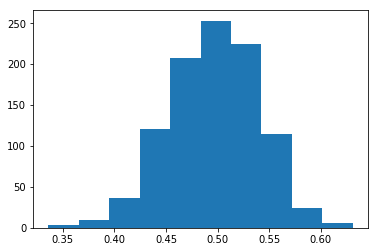

In [164]:
plt.hist(array_Q)
print(np.std(array_Q))